In [3]:
import numpy as np
from math import floor, pi, sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    n = len(qr)
    bitstr = format(target, f"0{n}b")[::-1]  # reversed: q[0] is LSB in qiskit ordering
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]
    for i in zero_positions:
        qc.x(qr[i])
    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    for i in zero_positions:
        qc.x(qr[i])

def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    n = len(qr)
    qc.h(qr)
    qc.x(qr)

    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)

    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int = None):
    if target < 0 or target >= 2**n:
        raise ValueError("target must be in range [0, 2^n - 1]")
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    qc.h(qr)
    N = 2**n
    if iterations is None:
        r = max(1, int(floor((pi / 4) * sqrt(N))))
    else:
        r = int(iterations)
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    qc.measure(qr, cr)
    return qc, r


n = 3
target = 5 
iterations = None

qc, r_used = build_grover_circuit(n, target, iterations)
print(f"Built Grover circuit for n={n}, target={target}, iterations={r_used}")
fig = qc.draw(output="mpl", idle_wires=False)
plt.show(fig)
backend = AerSimulator()
compiled = transpile(qc, backend)
job = backend.run(compiled, shots=2048)
result = job.result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts)
plt.show()
most_likely = max(counts, key=counts.get)
print(f"Most likely measured state: {most_likely}  (note: qubit-0 is the least significant bit)")

Built Grover circuit for n=3, target=5, iterations=2
Counts: {'000': 18, '010': 21, '100': 19, '111': 12, '011': 20, '110': 19, '001': 15, '101': 1924}
Most likely measured state: 101  (note: qubit-0 is the least significant bit)


In [4]:
import numpy as np
from math import floor, pi, sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    n = len(qr)
    bitstr = format(target, f"0{n}b")[::-1]  # reversed: q[0] is LSB in qiskit ordering
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]
    for i in zero_positions:
        qc.x(qr[i])
    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    for i in zero_positions:
        qc.x(qr[i])

def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    n = len(qr)
    qc.h(qr)
    qc.x(qr)

    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)

    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int = None):

    if target < 0 or target >= 2**n:
        raise ValueError("target must be in range [0, 2^n - 1]")
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    qc.h(qr)
    N = 2**n
    if iterations is None:
        r = max(1, int(floor((pi / 4) * sqrt(N))))
    else:
        r = int(iterations)
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    qc.measure(qr, cr)
    return qc, r

def run_grover_2qubit(target_binary: str, shots: int = 1024, show_circuit: bool = True):
    if len(target_binary) != 2 or any(c not in "01" for c in target_binary):
        raise ValueError("target_binary must be a 2-character string of '0'/'1', e.g. '10'")
    target_int = int(target_binary, 2)
    n = 2
    iterations = 1  # Exactly one Grover iteration as requested
    qc, r_used = build_grover_circuit(n, target_int, iterations)
    print(f"Running Grover (n={n}) searching for |{target_binary}> (integer {target_int}), iterations={r_used}")
    if show_circuit:
        fig = qc.draw(output="mpl", idle_wires=False)
        plt.show(fig)
    backend = AerSimulator()
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print("Counts:", counts)
    plot_histogram(counts)
    plt.show()

    most_likely = max(counts, key=counts.get)
    print(f"Most likely measured state: {most_likely}  (string shown MSB...LSB)")

if __name__ == "__main__":
    run_grover_2qubit("10", shots=1024)


Running Grover (n=2) searching for |10> (integer 2), iterations=1
Counts: {'10': 1024}
Most likely measured state: 10  (string shown MSB...LSB)


Scanning r = 1..20 for target |101> (int 5), shots=1024
r= 1  empirical=0.7783 (797/1024)  theoretical=0.7812
r= 2  empirical=0.9434 (966/1024)  theoretical=0.9453
r= 3  empirical=0.3506 (359/1024)  theoretical=0.3301
r= 4  empirical=0.0156 (16/1024)  theoretical=0.0122
r= 5  empirical=0.5381 (551/1024)  theoretical=0.5480
r= 6  empirical=1.0000 (1024/1024)  theoretical=0.9998
r= 7  empirical=0.5752 (589/1024)  theoretical=0.5770
r= 8  empirical=0.0205 (21/1024)  theoretical=0.0195
r= 9  empirical=0.2930 (300/1024)  theoretical=0.3029
r=10  empirical=0.9141 (936/1024)  theoretical=0.9313
r=11  empirical=0.8105 (830/1024)  theoretical=0.8049
r=12  empirical=0.1475 (151/1024)  theoretical=0.1450
r=13  empirical=0.0977 (100/1024)  theoretical=0.1063
r=14  empirical=0.7627 (781/1024)  theoretical=0.7566
r=15  empirical=0.9658 (989/1024)  theoretical=0.9578
r=16  empirical=0.3652 (374/1024)  theoretical=0.3578
r=17  empirical=0.0059 (6/1024)  theoretical=0.0066
r=18  empirical=0.5078 (520/1

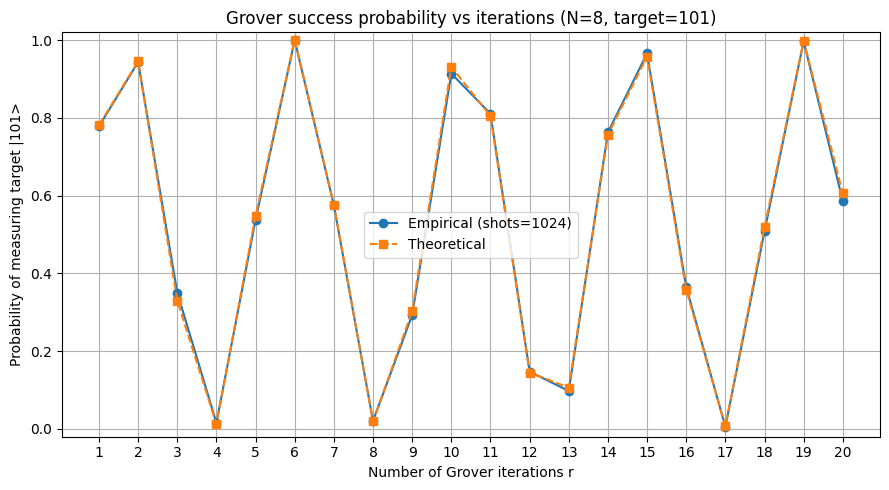

Best empirical r = 6 with empirical prob 1.0000
Counts for r=6: {'101': 1024}


In [5]:
import numpy as np
from math import asin, sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    n = len(qr)
    bitstr = format(target, f"0{n}b")[::-1]  # reversed: q[0] is LSB in qiskit ordering
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]
    for i in zero_positions:
        qc.x(qr[i])
    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    for i in zero_positions:
        qc.x(qr[i])

def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    n = len(qr)
    qc.h(qr)
    qc.x(qr)

    if n == 1:
        qc.z(qr[0])
    elif n == 2:
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        qc.h(target_qubit)
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)

    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int):
    if target < 0 or target >= 2**n:
        raise ValueError("target must be in range [0, 2^n - 1]")
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    qc.h(qr)
    r = int(iterations)
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    qc.measure(qr, cr)
    return qc

def theoretical_probability(N: int, r: int) -> float:
    theta = asin(1.0 / sqrt(N))
    return np.sin((2 * r + 1) * theta) ** 2

def run_grover_3qubit_scan(target_binary: str = "101", r_max: int = 20, shots: int = 1024):
    if len(target_binary) != 3 or any(c not in "01" for c in target_binary):
        raise ValueError("target_binary must be a 3-character string of '0'/'1', e.g. '101'")

    target_int = int(target_binary, 2)
    N = 2 ** 3
    backend = AerSimulator()

    rs = list(range(1, r_max + 1))
    empirical_probs = []
    theoretical_probs = []

    print(f"Scanning r = 1..{r_max} for target |{target_binary}> (int {target_int}), shots={shots}")
    for r in rs:
        qc = build_grover_circuit(3, target_int, iterations=r)
        compiled = transpile(qc, backend)
        job = backend.run(compiled, shots=shots)
        result = job.result()
        counts = result.get_counts()
        # counts keys are strings like "q2 q1 q0" as "b2b1b0" (MSB..LSB), so we can use target_binary directly
        success_counts = counts.get(target_binary, 0)
        p_emp = success_counts / shots
        p_theo = theoretical_probability(N, r)
        empirical_probs.append(p_emp)
        theoretical_probs.append(p_theo)
        print(f"r={r:2d}  empirical={p_emp:.4f} ({success_counts}/{shots})  theoretical={p_theo:.4f}")

    plt.figure(figsize=(9, 5))
    plt.plot(rs, empirical_probs, 'o-', label='Empirical (shots={})'.format(shots))
    plt.plot(rs, theoretical_probs, 's--', label='Theoretical')
    plt.xlabel('Number of Grover iterations r')
    plt.ylabel('Probability of measuring target |{}>'.format(target_binary))
    plt.title('Grover success probability vs iterations (N=8, target={})'.format(target_binary))
    plt.xticks(rs)
    plt.ylim(-0.02, 1.02)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    best_r_emp = rs[int(np.argmax(empirical_probs))]
    print(f"Best empirical r = {best_r_emp} with empirical prob {max(empirical_probs):.4f}")
    qc_best = build_grover_circuit(3, target_int, iterations=best_r_emp)
    compiled_best = transpile(qc_best, backend)
    job_best = backend.run(compiled_best, shots=shots)
    result_best = job_best.result()
    counts_best = result_best.get_counts()
    print(f"Counts for r={best_r_emp}: {counts_best}")
    plot_histogram(counts_best)
    plt.show()

if __name__ == "__main__":
    run_grover_3qubit_scan(target_binary="101", r_max=20, shots=1024)
